# Homework 3
*Tuğberk Dikmen 21802480*

This homework done and tested on local Macbook Air with M2 chip. Due to network issues it does not tested with Google Colab, please run this .ipynb file on your local machine.

In order to see the results part, your local machine should be connected to internet.

# Imports and Requirements

In [1]:
# Tuğberk Dikmen 21802480
# Homework - 3

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os

# Environment Check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(464)

/Users/tugberkdikmen/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/tugberkdikmen/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current device: cpu


# PART 1 Preparing the Dataset

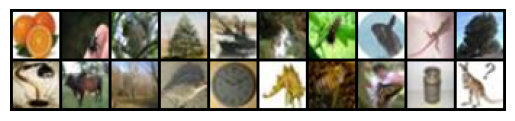

In [2]:
class CifarDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Initialize the dataset.
        :param root_dir: Root directory of the dataset containing class subdirectories.
        :param transform: Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.file_names = []

        # Iterate over all class folders
        for class_folder in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_folder)

            # Check if it's a directory
            if os.path.isdir(class_dir):
                # Extend the file list with the paths of images in the current class folder
                self.file_names.extend([
                    os.path.join(class_dir, file)
                    for file in os.listdir(class_dir)
                    if file.lower().endswith(('.jpg', '.jpeg', '.png'))
                ])

    def __len__(self):
        """
        Return the total number of images in the dataset.
        """
        return len(self.file_names)

    def __getitem__(self, idx):
        """
        Fetch the image and apply transformations.
        :param idx: Index of the image to be fetched.
        :return: Transformed image.
        """
        img_path = self.file_names[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# Transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((32, 32), interpolation=transforms.InterpolationMode.BICUBIC),  # Resize
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Dataset and DataLoader
train_dataset = CifarDataset(root_dir='cifar100/train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = CifarDataset(root_dir='cifar100/test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Uncomment the cell when the dataloader is ready

images = next(iter(train_dataloader)) # Taking one batch from the dataloader
images = (images + 1) / 2
grid_img = torchvision.utils.make_grid(images[:20], nrow=10)
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

# PART 2 Constructing Convolutional Autoencoder Network

In [3]:
# Convolutional Autoencoder
class CifarAutoencoder(nn.Module):
    def __init__(self):
        super(CifarAutoencoder, self).__init__()

        # Encoder with Max Pooling
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # Output size: 8x8
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1), # Output size: 16x16
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),   # Output size: 32x32
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# PART 3 the Training Loop

In [4]:
# Training Loop with Image Masking
def train_model(model, dataloader, criterion, optimizer, num_epochs):
    model.train()
    epoch_losses = []  # List to store epoch losses

    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in dataloader:
            inputs = data.clone().to(device)  # Clone the original image
            inputs[:, :, :, 16:32] = -1  # Mask the input image

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, data.to(device))  # Use original image as ground truth
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloader)
        epoch_losses.append(epoch_loss)  # Store the epoch loss
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    return model, epoch_losses

# PART 4 Evaluation Function

In [5]:
# Evaluation Function
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for data in dataloader:
            inputs = data.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            total_loss += loss.item()
    mean_loss = total_loss / len(dataloader)
    return mean_loss

# PART 5 Inpainting Visualization Function

In [6]:
def visualize_inpainting(model, dataset):
    seed_everything(464)
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
    images = next(iter(dataloader)) # Taking one batch from the dataloader
    images = images
    model.eval()
    with torch.no_grad():
      masked_images = images.clone()
      masked_images[:,:,:,16:] = -1
      inpainted_images = model(masked_images.to(device)).to('cpu')
    images = (images + 1) / 2
    masked_images = (masked_images + 1) / 2
    inpainted_images = (inpainted_images + 1) / 2
    images_concat = torch.cat((images, masked_images, inpainted_images), dim=2)
    grid_img = torchvision.utils.make_grid(images_concat, nrow=10)
    plt.axis('off')
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

inpainted_images = model(masked_images.cuda()).cpu()

line changed to

inpainted_images = model(masked_images.to(device)).to('cpu')

in order to run the code on local m2 chip.


# Part 6 Plot Training Loss

In [7]:
# Plotting the training loss
def plot_training_loss(epoch_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(epoch_losses, label='Training Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# PART 7 Train and Evaluate the Model

Epoch 1/50, Loss: 0.1230
Epoch 2/50, Loss: 0.0918
Epoch 3/50, Loss: 0.0872
Epoch 4/50, Loss: 0.0849
Epoch 5/50, Loss: 0.0830
Epoch 6/50, Loss: 0.0819
Epoch 7/50, Loss: 0.0810
Epoch 8/50, Loss: 0.0805
Epoch 9/50, Loss: 0.0799
Epoch 10/50, Loss: 0.0792
Epoch 11/50, Loss: 0.0788
Epoch 12/50, Loss: 0.0786
Epoch 13/50, Loss: 0.0782
Epoch 14/50, Loss: 0.0778
Epoch 15/50, Loss: 0.0776
Epoch 16/50, Loss: 0.0774
Epoch 17/50, Loss: 0.0770
Epoch 18/50, Loss: 0.0769
Epoch 19/50, Loss: 0.0766
Epoch 20/50, Loss: 0.0764
Epoch 21/50, Loss: 0.0762
Epoch 22/50, Loss: 0.0760
Epoch 23/50, Loss: 0.0761
Epoch 24/50, Loss: 0.0757
Epoch 25/50, Loss: 0.0757
Epoch 26/50, Loss: 0.0755
Epoch 27/50, Loss: 0.0752
Epoch 28/50, Loss: 0.0752
Epoch 29/50, Loss: 0.0750
Epoch 30/50, Loss: 0.0749
Epoch 31/50, Loss: 0.0747
Epoch 32/50, Loss: 0.0747
Epoch 33/50, Loss: 0.0744
Epoch 34/50, Loss: 0.0743
Epoch 35/50, Loss: 0.0743
Epoch 36/50, Loss: 0.0741
Epoch 37/50, Loss: 0.0740
Epoch 38/50, Loss: 0.0739
Epoch 39/50, Loss: 0.

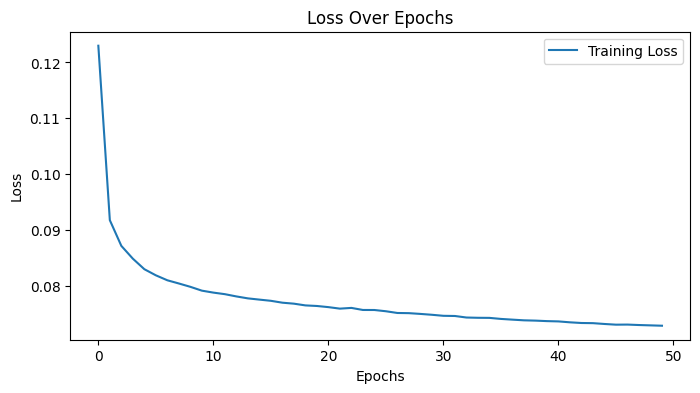

Mean Loss on Test Set: 0.0676


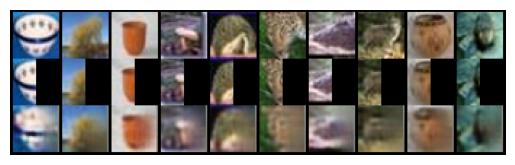

In [10]:
# Model, Loss, and Optimizer
seed_everything(464)
model = CifarAutoencoder().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# Training
num_epochs = 50
trained_model, epoch_losses = train_model(model, train_dataloader, criterion, optimizer, num_epochs)

# Plotting the training loss
plot_training_loss(epoch_losses)

# Evaluation
mean_loss = evaluate_model(trained_model, test_dataloader, criterion)  # trained_model
print(f'Mean Loss on Test Set: {mean_loss:.4f}')

visualize_inpainting(trained_model, test_dataset)

# PART 8 Results

#*Part 1 Visualize Data*

![Part 1 Visualize Data](https://drive.google.com/uc?id=1J4rnF_UZiVuteYQgmVQPT0BuuxgAHeeh)

#*Loss x Epoc Graph*

![Loss x Epoc Graph](https://drive.google.com/uc?id=1JTTtyOdMHhuKSNRHiO4ydonua8HBgUTh)

#*Loss in each Epoc*

![Loss in each Epoc](https://drive.google.com/uc?id=1lTGDMD3FD7twmAThOHl7DHeujWBtS3ZS)

#*Mean Loss on Test Set*

![Mean Loss on Test Set](https://drive.google.com/uc?id=1OPG6hKp1Z33JdEs43Z8y1yP-9Su3tYWk)

#*Final Results*

![Final Results](https://drive.google.com/uc?id=1JjEIDsLQgnaVHXyl96LWGde_aJErtqY4)